# `predicting_when_longshot_occurs.ipynb`

### Author: Anthony Hein

#### Last updated: 11/8/2021

# Overview:

This notebook shows that longshots do well in extreme weather conditions.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style="whitegrid")

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `races_featurized.csv`

In [3]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/streamline/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,1,1.350363
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,1,0,0,1,0,0,0,0,1,1.995151
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,1,0,0,0,0,0,0,1,0,1.786421
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,1,0,1.611062
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,1,0,0,0,0,0,1,0,0,1.254374


In [4]:
races_featurized.shape

(20201, 129)

In [90]:
list(races_featurized.columns)

['rid',
 'course',
 'title',
 'winningTime',
 'metric',
 'ncond',
 'class',
 'runners',
 'margin',
 '1st_place_rank_in_odds',
 '2nd_place_rank_in_odds',
 '3rd_place_rank_in_odds',
 '1st_rank_in_odds_place',
 '2nd_rank_in_odds_place',
 '3rd_rank_in_odds_place',
 'placeAvailable',
 'showAvailable',
 'favoriteWon',
 'favoritePlaced',
 'favoriteShowed',
 'lat',
 'lng',
 'datetime',
 'station no',
 'station name',
 'station lat',
 'station lng',
 'dist to station',
 'station reading date',
 'temp',
 'msl',
 'rain',
 'rhum',
 'station reading timedelta',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 '

In [89]:
races_featurized = races_featurized.drop(columns=['entropy of odds'])

In [131]:
races_featurized['runners'].value_counts()

14    3444
13    2161
10    2052
9     2029
12    1972
8     1920
11    1878
7     1724
6     1254
5     1057
4      525
3      185
Name: runners, dtype: int64

In [132]:
races_featurized = races_featurized[races_featurized['runners'] == 14]

---

## Predicting When Longshots Occur

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [134]:
races_featurized_trunc = races_featurized.drop(columns=[
    'rid',
    'course',
    'title',
    'winningTime',
    'placeAvailable',
    'showAvailable',
    '1st_place_rank_in_odds',
    '2nd_place_rank_in_odds',
    '3rd_place_rank_in_odds',
    '1st_rank_in_odds_place',
    '2nd_rank_in_odds_place',
    '3rd_rank_in_odds_place',
    'favoriteWon',
    'favoritePlaced',
    'favoriteShowed',
    'lat',
    'lng',
    'datetime',
    'station no',
    'station name',
    'station lat',
    'station lng',
    'dist to station',
    'station reading date',
    'temp',
    'msl',
    'rain',
    'rhum',
    'station reading timedelta',
])
races_featurized_trunc.head()

,metric,ncond,class,runners,margin,course__Ballinrobe,course__Bellewstown,course__Clonmel,course__Cork,course__Curragh,...,pressure_level_1,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4
345,5028.0,5,0,14,1.468367,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
429,2111.5,0,0,14,1.243227,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
430,2111.5,0,0,14,1.297882,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
431,1407.0,0,0,14,1.286172,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
432,1609.0,0,0,14,1.297451,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [135]:
list(races_featurized_trunc.columns)

['metric',
 'ncond',
 'class',
 'runners',
 'margin',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 'course__Tipperary',
 'course__Tralee',
 'course__Tramore',
 'course__Wexford',
 'metric__1005.0',
 'metric__1206.0',
 'metric__1306.5',
 'metric__1407.0',
 'metric__1507.5',
 'metric__1609.0',
 'metric__1709.5',
 'metric__1810.0',
 'metric__1910.5',
 'metric__2011.0',
 'metric__2111.5',
 'metric__2212.0',
 'metric__2413.0',
 'metric__2614.0',
 'metric__2815.0',
 'metric__3218.0',
 'metric__3419.0',
 'metric__3620.0',
 'metric__4022.0',
 'metric__Other',
 'ncond__0',
 'ncond__1',
 'ncond__2',
 'nc

In [168]:
target = races_featurized['1st_place_rank_in_odds'] > 3

In [169]:
races_featurized_scaled = StandardScaler().fit_transform(races_featurized_trunc)
races_featurized_scaled

array([[ 3.91828059,  0.66353655,  0.        , ..., -0.55991173,
         1.34674626, -0.72240821],
       [ 0.18118969, -0.74431207,  0.        , ..., -0.55991173,
        -0.74253037,  1.38425891],
       [ 0.18118969, -0.74431207,  0.        , ..., -0.55991173,
        -0.74253037,  1.38425891],
       ...,
       [ 1.59901622,  0.66353655,  0.        , ..., -0.55991173,
         1.34674626, -0.72240821],
       [ 1.59901622,  1.78981545,  0.        , ..., -0.55991173,
         1.34674626, -0.72240821],
       [ 1.59901622,  1.78981545,  0.        , ..., -0.55991173,
        -0.74253037,  1.38425891]])

In [170]:
X_train, X_test, y_train, y_test = train_test_split(races_featurized_scaled, target, test_size=0.3, random_state=42)

In [171]:
lr = LogisticRegression(random_state=0, max_iter=1000)
probs = lr.fit(X_train, y_train).predict_proba(X_test)

In [165]:
metrics.confusion_matrix(y_test, lr.fit(X_train, y_train).predict(X_test))

array([[270, 221],
       [290, 253]])

In [166]:
lr.score(X_train, y_train)

0.5804979253112034

In [167]:
lr.score(X_test, y_test)

0.5058027079303675

In [148]:
probs_pos = [prob[1] for prob in probs]

In [149]:
fprs, tprs, thresholds = metrics.roc_curve(y_test, probs_pos, pos_label=1)
roc_auc = metrics.auc(fprs, tprs)

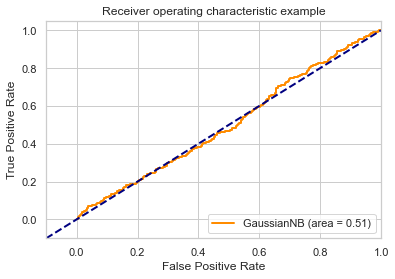

In [150]:
plt.figure()
lw = 2
plt.plot(
    fprs,
    tprs,
    color="darkorange",
    lw=lw,
    label="GaussianNB (area = %0.2f)" % roc_auc,
)
plt.plot([-0.1, 1], [-0.1, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [151]:
lr.coef_

array([[ 0.08550387, -0.64562731,  0.        ,  0.        , -0.06239853,
         0.0016469 , -0.00995388,  0.06184845,  0.0865089 ,  0.10170482,
         0.09642683, -0.04324273, -0.31712892,  0.08367488,  0.00271353,
         0.03372437,  0.13053603,  0.04605107,  0.13297299, -0.00452529,
         0.02729744,  0.00795972,  0.00687694, -0.03309959,  0.04541868,
         0.05640597, -0.02034209,  0.00952511,  0.08320159,  0.06075498,
         0.03401579,  0.10541   ,  0.03859324, -0.07969116,  0.01201088,
        -0.06015592,  0.0340432 ,  0.12060463,  0.04305954,  0.01803968,
         0.00512616, -0.02511084, -0.00736365,  0.03633803, -0.09391215,
         0.0053697 , -0.0541114 ,  0.02769373, -0.02455439, -0.02390669,
         0.11578916, -0.25529007, -0.14325873, -0.06776476, -0.08944467,
         0.02351696,  0.12360343,  0.16101602,  0.16444782,  0.14885365,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [152]:
races_featurized_trunc_no_weather = races_featurized_trunc.drop(columns=[
    'temp_level_0',
    'temp_level_1',
    'temp_level_2',
    'temp_level_3',
    'temp_level_4',
    'pressure_level_0',
    'pressure_level_1',
    'pressure_level_2',
    'pressure_level_3',
    'pressure_level_4',
    'is_raining',
    'rhum_level_0',
    'rhum_level_1',
    'rhum_level_2',
    'rhum_level_3',
    'rhum_level_4',
])
races_featurized_trunc_no_weather.head()

,metric,ncond,class,runners,margin,course__Ballinrobe,course__Bellewstown,course__Clonmel,course__Cork,course__Curragh,...,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,month__Other,year
345,5028.0,5,0,14,1.468367,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1992
429,2111.5,0,0,14,1.243227,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2018
430,2111.5,0,0,14,1.297882,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2018
431,1407.0,0,0,14,1.286172,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2018
432,1609.0,0,0,14,1.297451,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2018


In [153]:
list(races_featurized_trunc_no_weather.columns)

['metric',
 'ncond',
 'class',
 'runners',
 'margin',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 'course__Tipperary',
 'course__Tralee',
 'course__Tramore',
 'course__Wexford',
 'metric__1005.0',
 'metric__1206.0',
 'metric__1306.5',
 'metric__1407.0',
 'metric__1507.5',
 'metric__1609.0',
 'metric__1709.5',
 'metric__1810.0',
 'metric__1910.5',
 'metric__2011.0',
 'metric__2111.5',
 'metric__2212.0',
 'metric__2413.0',
 'metric__2614.0',
 'metric__2815.0',
 'metric__3218.0',
 'metric__3419.0',
 'metric__3620.0',
 'metric__4022.0',
 'metric__Other',
 'ncond__0',
 'ncond__1',
 'ncond__2',
 'nc

In [154]:
races_featurized_scaled_no_weather = StandardScaler().fit_transform(races_featurized_trunc_no_weather)
races_featurized_scaled_no_weather

array([[ 3.91828059,  0.66353655,  0.        , ..., -0.2687548 ,
        -0.27369028, -3.15359694],
       [ 0.18118969, -0.74431207,  0.        , ..., -0.2687548 ,
         3.65376518,  1.05445725],
       [ 0.18118969, -0.74431207,  0.        , ..., -0.2687548 ,
         3.65376518,  1.05445725],
       ...,
       [ 1.59901622,  0.66353655,  0.        , ..., -0.2687548 ,
        -0.27369028, -2.02065927],
       [ 1.59901622,  1.78981545,  0.        , ...,  3.72086382,
        -0.27369028, -2.02065927],
       [ 1.59901622,  1.78981545,  0.        , ...,  3.72086382,
        -0.27369028, -2.02065927]])

In [155]:
X_train, X_test, y_train, y_test = train_test_split(races_featurized_scaled_no_weather, target, test_size=0.3, random_state=42)

In [156]:
lr = LogisticRegression(random_state=0, max_iter=1000)
probs = lr.fit(X_train, y_train).predict_proba(X_test)

In [157]:
metrics.confusion_matrix(y_test, lr.fit(X_train, y_train).predict(X_test))

array([[549,  80],
       [352,  53]])

In [158]:
lr.score(X_train, y_train)

0.604149377593361

In [159]:
lr.score(X_test, y_test)

0.5822050290135397

In [160]:
lr.coef_

array([[ 0.09936196, -0.58533044,  0.        ,  0.        , -0.06749099,
         0.00621928, -0.00851996,  0.04820714,  0.07395275,  0.08046536,
         0.08690557, -0.0412558 , -0.27423604,  0.07023147,  0.00828934,
         0.02541862,  0.12624657,  0.04514623,  0.12183244, -0.02129245,
         0.02225036,  0.00659461,  0.01103023, -0.03635299,  0.04777982,
         0.05488695, -0.01586282,  0.00554049,  0.05846199,  0.04801553,
         0.03117271,  0.10225678,  0.04296533, -0.07973783,  0.00983264,
        -0.05815224,  0.02663198,  0.11332084,  0.02975012,  0.0178211 ,
         0.01092487, -0.0232685 ,  0.00427475,  0.03210763, -0.09422843,
         0.00059312, -0.05085019,  0.02560724, -0.02043702, -0.02556303,
         0.13607459, -0.24553339, -0.15128804, -0.06023951, -0.07942859,
         0.02027661,  0.11298348,  0.13412901,  0.14770902,  0.12149944,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 